In [1]:
import os
import re
import numpy as np
import pandas as pd

# Import the necessary word lists (harvard_wordlist and lm_neg_wordlist)
import harvard_wordlist
import lm_neg_wordlist

# Load the CSV file into a DataFrame
df = pd.read_csv('scores.csv')

df

,ticker,file_number,date,word_count,words,excess_returns
0,SNA,0000091440-21-000011.txt,2021-04-22,13001,"['sna', 'htm', 'sna', 'gaap', 'gaap', 'propert...",-0.003843
1,MCK,0000927653-20-000093.txt,2020-11-03,17989,"['mck', 'htm', 'mck', 'gaap', 'gaap', 'usdxbrl...",0.052555
2,HSIC,0001000228-20-000055.txt,2020-08-04,20228,"['htm', 'quarterly', 'report', 'truetruemodifi...",-0.027407
3,CME,0001156375-21-000052.txt,2021-05-05,7184,"['cme', 'htm', 'cme', 'gaap', 'gaap', 'gaap', ...",0.023516
4,WTW,0001564590-18-026537.txt,2018-11-02,24493,"['wltw', 'htm', 'wltw', 'htm', 'united', 'stat...",0.015161
...,...,...,...,...,...,...
7299,MCK,0000927653-21-000065.txt,2021-08-05,14680,"['mck', 'htm', 'mck', 'gaap', 'usdxbrli', 'gaa...",-0.023552
7300,YUM,0001041061-19-000048.txt,2019-11-05,10695,"['yum', 'htm', 'document', 'false', 'yum', 're...",0.008845
7301,PARA,0000813828-19-000033.txt,2019-11-12,18320,"['htm', 'document', 'us', 'gaap', 'commonclass...",0.019004
7302,TMUS,0001283699-22-000117.txt,2022-07-29,14902,"['tmus', 'htm', 'tmus', 'form', 'tmus', 'usdxb...",-0.004576


### calculating the hiv4 and lm scores

In [2]:
# Define the word lists
hiv4_list = harvard_wordlist.harvard_neg
lm_neg_list = lm_neg_wordlist.lm_negative

# Convert the words in the word lists to lowercase
hiv4_list = [word.lower() for word in hiv4_list]
lm_neg_list = [word.lower() for word in lm_neg_list]

# Initialize DataFrames for term frequency/word count and proportional weighting
hiv4_wc = pd.DataFrame(columns=hiv4_list)
lm_wc = pd.DataFrame(columns=lm_neg_list)
hiv4_pw = pd.DataFrame(columns=hiv4_list)
lm_pw = pd.DataFrame(columns=lm_neg_list)

# Initialize dictionaries to count word occurrences
hiv4_df_dict = {word: 0 for word in hiv4_list}
lm_df_dict = {word: 0 for word in lm_neg_list}

# Helper function to read file_content from file_path
def read_words(word_list):
    return [word.strip() for word in re.findall(r'\b\w+\b', word_list.lower())]

# Count the occurrence of one specific negative word in a specific row
def tf(words, word_list):
    word_counts = {word: 0 for word in word_list}
    for word in words:
        if word in word_list:
            word_counts[word] += 1
    return word_counts

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    words = read_words(row['words'])
    
    # Calculate word counts and proportional weights for hiv4 and lm
    hiv4_wc_dict = tf(words, hiv4_list)
    hiv4_pw_dict = {key: value / len(words) if len(words) != 0 else 0 for key, value in hiv4_wc_dict.items()}
    hiv4_wc.loc[index] = hiv4_wc_dict.values()
    hiv4_pw.loc[index] = hiv4_pw_dict.values()

    lm_wc_dict = tf(words, lm_neg_list)
    lm_pw_dict = {key: value / len(words) if len(words) != 0 else 0 for key, value in lm_wc_dict.items()}
    lm_wc.loc[index] = lm_wc_dict.values()
    lm_pw.loc[index] = lm_pw_dict.values()

    for word in words:
        if word in hiv4_list:
            hiv4_df_dict[word] += 1
        if word in lm_neg_list:
            lm_df_dict[word] += 1

# Calculate the total number of rows (N)
N = len(df)

# Calculate the average number of words in documents
average_word_count = df['word_count'].mean()

# Term weighting function
def transform_value(x):
    return (1 + np.log(x)) / (1 + np.log(average_word_count)) if x != 0 else 0

# Save proportional weighting results to CSV
hiv4_pw.to_csv("hiv4_pw.csv")
lm_pw.to_csv("lm_pw.csv")

# Calculate inverse document frequency (IDF) values
hiv4_idf_dict = {key: (1 / value) * N if value != 0 else 0 for key, value in hiv4_df_dict.items()}
lm_idf_dict = {key: (1 / value) * N if value != 0 else 0 for key, value in lm_df_dict.items()}

# Transform the hiv4_wc and lm_wc term frequency dataframes
hiv4_tw = hiv4_wc.applymap(transform_value) * pd.Series(hiv4_idf_dict)
lm_tw = lm_wc.applymap(transform_value) * pd.Series(lm_idf_dict)

# Initialize a DataFrame for text negativity scores

df['hiv4_pw'] = hiv4_pw.sum(axis=1)
df['lm_pw'] = lm_pw.sum(axis=1)
df['hiv4_tw'] = hiv4_tw.sum(axis=1)
df['lm_tw'] = lm_tw.sum(axis=1)



In [3]:
df.head()

,ticker,file_number,date,word_count,words,excess_returns,hiv4_pw,lm_pw,hiv4_tw,lm_tw
0,SNA,0000091440-21-000011.txt,2021-04-22,13001,"['sna', 'htm', 'sna', 'gaap', 'gaap', 'propert...",-0.003843,0.018845,0.016999,11.175217,61.330539
1,MCK,0000927653-20-000093.txt,2020-11-03,17989,"['mck', 'htm', 'mck', 'gaap', 'gaap', 'usdxbrl...",0.052555,0.024070,0.031075,278.150231,67.338525
2,HSIC,0001000228-20-000055.txt,2020-08-04,20228,"['htm', 'quarterly', 'report', 'truetruemodifi...",-0.027407,0.028970,0.036929,47.249262,346.221181
3,CME,0001156375-21-000052.txt,2021-05-05,7184,"['cme', 'htm', 'cme', 'gaap', 'gaap', 'gaap', ...",0.023516,0.025195,0.017261,9.264812,25.116045
4,WTW,0001564590-18-026537.txt,2018-11-02,24493,"['wltw', 'htm', 'wltw', 'htm', 'united', 'stat...",0.015161,0.026457,0.035969,48.397876,541.614115


In [4]:
# Save the scores to a CSV file
df.to_csv('scores.csv', index=False)

### calculate ranks and median

In [5]:
# Calculate quantiles and add them to the original df DataFrame
df['lm_rank'] = df['lm_tw'].rank(method='first')
df['hiv4_rank'] = df['hiv4_tw'].rank(method='first')
df['lm_pw_rank'] = df['lm_pw'].rank(method='first')
df['hiv4_pw_rank'] = df['hiv4_pw'].rank(method='first')

bin_labels = ['5', '4', '3', '2', '1']

df['lm_quantile'] = pd.qcut(df['lm_rank'].astype(int), 5, labels=bin_labels)
df['hiv4_quantile'] = pd.qcut(df['hiv4_rank'].astype(int), 5, labels=bin_labels)
df['lm_pw_quantile'] = pd.qcut(df['lm_pw_rank'].astype(int), 5, labels=bin_labels)
df['hiv4_pw_quantile'] = pd.qcut(df['hiv4_pw_rank'].astype(int), 5, labels=bin_labels)

# If you want to save the modified df to a CSV file, you can do it as follows:
#df.to_csv('modified_df.csv', index=False)
# Select the desired columns from df and create a new DataFrame quantile
quantile = df[['ticker','file_number', 'excess_returns', 'lm_quantile', 'hiv4_quantile', 'lm_pw_quantile', 'hiv4_pw_quantile']]

# Display the first few rows of the quantile DataFrame
quantile.head()

,ticker,file_number,excess_returns,lm_quantile,hiv4_quantile,lm_pw_quantile,hiv4_pw_quantile
0,SNA,0000091440-21-000011.txt,-0.003843,3,5,4,4
1,MCK,0000927653-20-000093.txt,0.052555,3,1,2,2
2,HSIC,0001000228-20-000055.txt,-0.027407,1,2,1,1
3,CME,0001156375-21-000052.txt,0.023516,5,5,4,2
4,WTW,0001564590-18-026537.txt,0.015161,1,2,1,2


In [6]:
# Calculate medians for each quantile group for lm_quantile
lm_quantile_median = quantile.groupby(['lm_quantile']).median(numeric_only=True)

# Calculate medians for each quantile group for hiv4_quantile
hiv4_quantile_median = quantile.groupby(['hiv4_quantile']).median(numeric_only=True)

# Calculate medians for each quantile group for lm_pw_quantile
lm_pw_quantile_median = quantile.groupby(['lm_pw_quantile']).median(numeric_only=True)

# Calculate medians for each quantile group for hiv4_pw_quantile
hiv4_pw_quantile_median = quantile.groupby(['hiv4_pw_quantile']).median(numeric_only=True)


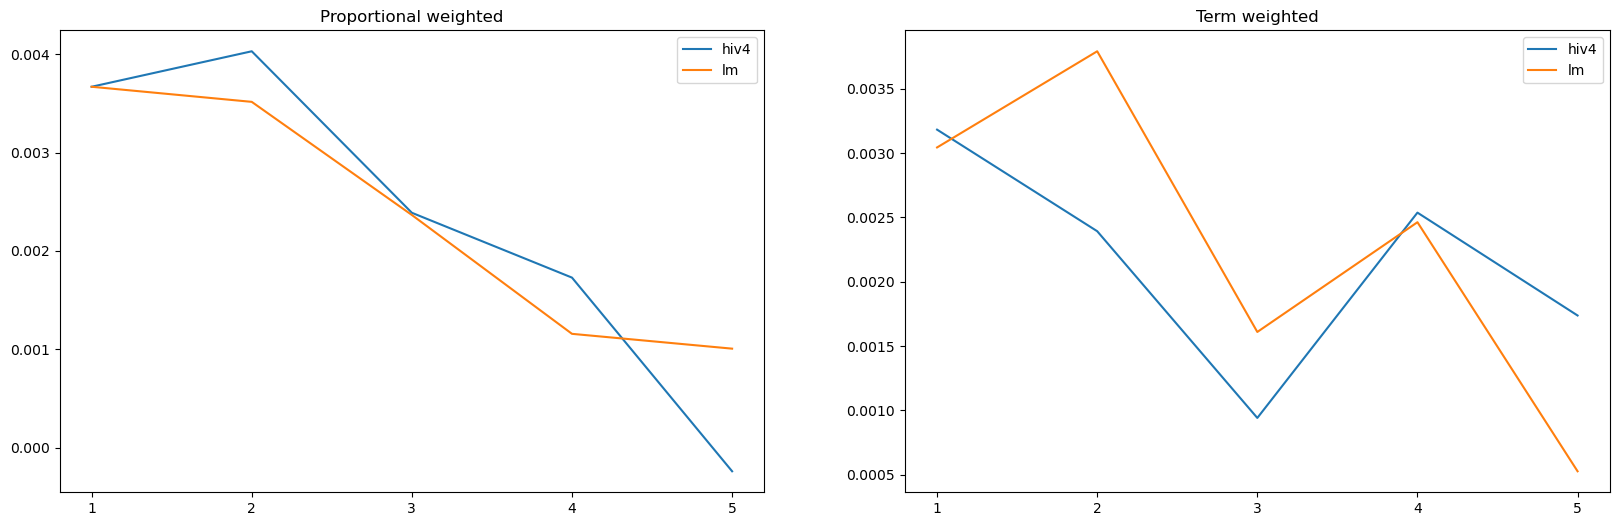

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

ax1.plot(hiv4_pw_quantile_median, label='hiv4')
ax1.plot(lm_pw_quantile_median, label='lm')
ax1.invert_xaxis()
ax1.legend()
ax1.set_title("Proportional weighted")

ax2.plot(hiv4_quantile_median, label='hiv4')
ax2.plot(lm_quantile_median, label='lm')
ax2.invert_xaxis()
ax2.legend()
ax2.set_title("Term weighted")

plt.show()